# 基于商品名称的自动化分类

TASK 6+王沛然

**案例背景**： 商品分类，顾名思义就是根据商品的性质、特点将其划分到合适的类别中。在现代商业社会，商品分类是商品流通的基础步骤之一。目前的商品分类普遍存在三大困难：数据大、信息少、人工繁。本案例针对上述商品分类面对的困难，提出了一套基于商品名称的商品自动化分类体系，它可以完全利用商品名称信息，以自动化的分类技术大批量高效率的对海量商品进行分类处理，从而延伸商品价值。案例的更多背景请参考推文[基于商品名称的自动化分类|精品案例](https://mp.weixin.qq.com/s/sfPWSgiRLXEgH4UE7FHUsg)。

本案例的**学习目标**包括：<br>
1.学习进行基本的文本处理；<br>
2.学习如何对文本数据进行描述性分析；<br>
3.学习如何通过分类器对文本数据进行分类处理。

导入必要的包

In [1]:
import warnings #设置警告
import pandas as pd #数据处理
import matplotlib.pyplot as plt #可视化
import jieba #分词

from collections import Counter #统计列表中每个元素出现的次数
from imageio import imread #导入绘制词云图的图片
from wordcloud import WordCloud #绘制词云图
from sklearn.model_selection import train_test_split #训练集测试集分割
from sklearn.naive_bayes import MultinomialNB #朴素贝叶斯分类
from sklearn.metrics import confusion_matrix #计算混淆矩阵

plt.rcParams['font.sans-serif'] = ['Microsoft Yahei'] #显示中文：微软雅黑
warnings.filterwarnings('ignore') #不显示警告

## 任务一

设置好工作路径，找到数据集catalogs.csv。该数据里面包含每个商品的名称以及对应的一二三级分类。读入该数据，命名为catalog。然后，使用head()函数查看数据的基本形式。

In [2]:
#读取数据，查看前5行
catalog = pd.read_csv('catalogs.csv')
catalog.head()

,name,first,second,third
0,双汇 猪舌 700g/袋,生鲜,猪牛羊肉,猪肉
1,（满38减10）黑猪腊肉 湘西腊肉 即食小吃食猪肉干肉脯湖南张家界土家 香辣味,生鲜,猪牛羊肉,猪肉
2,精气神 猪肋排段（排骨） 400g/袋 山黑猪 黑猪肉 林间散养,生鲜,猪牛羊肉,猪肉
3,双汇 猪五花肉片 300g/袋 整肉原切 火锅食材,生鲜,猪牛羊肉,猪肉
4,农家散养新鲜现杀黑土猪肉 纯瘦肉 500g,生鲜,猪牛羊肉,猪肉


## 任务二

品类分布的描述性分析。数据中包含两个一级品类，即“生鲜”和“食品饮料、保健食品”（以下简称为“食品饮料”）。以“生鲜”类为例，使用饼图查看其各个二级品类的分布情况，并进行文字解读。

Text(0.5, 1.0, '生鲜类产品二级分类饼图')

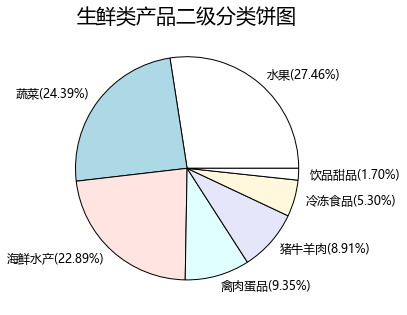

In [3]:
#准备数据和标签
fresh = catalog[catalog['first'] == '生鲜']
label = (round((fresh['second'].value_counts()/fresh['second'].value_counts().sum()),4)*100).map(lambda x:"%.2f%%"%x)

#绘制饼图
plt.figure(figsize = (5,6))
plt.pie(fresh['second'].value_counts().values #数据
       ,labels = label.index + '(' + label.values + ')' #标签
       ,colors = ['#FFFFFF', '#ADD8E6', '#FFE4E1', '#E0FFFF', '#E6E6FA', '#FFF8DC'] #颜色
       ,startangle = 0 #起始位置：x正半轴（默认）
       ,textprops = {'fontsize':12} #标签字体大小12
       ,wedgeprops = {'linewidth': 1, 'edgecolor': "black"} #线宽1，黑色
       )
plt.title('生鲜类产品二级分类饼图', fontsize = 20) #添加标题，字体大小20

解读：在所有生鲜类产品中，水果、蔬菜和海鲜水产占比最大，均在20%以上，且三者之和占比近3/4，其余的1/4主要是禽肉单品、猪牛羊肉、冷冻食品和饮品甜品。

## 任务三

商品名称的处理与分析。由于商品名称是非结构的文本数据，因此首先利用jieba包中的分词函数对商品名称进行分词处理。为了得到更为精确的分词结果，我们提供了一个自定义词典，即“userdict.dat”，里面是各种常见的食品和生鲜名称，请在jieba分词时加载该词典。以“生鲜类”为例，用直方图展示该类别下商品的分词数量分布，从中你有什么发现？

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\T14G1~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.727 seconds.
Prefix dict has been built successfully.


Text(0.5, 1.0, 'Histogram of word_lengths')

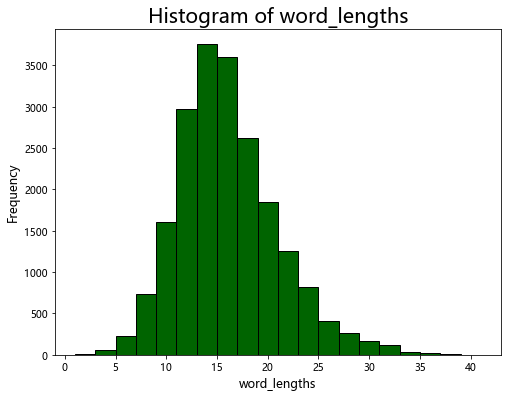

In [4]:
catalog[catalog['first'] == '生鲜']['name'].isna().sum() #有1个缺失值
freshname = catalog[catalog['first'] == '生鲜']['name'].dropna().values

#读入停用词
stopwords = pd.read_table('停用词.txt', names=['stopword']) #导入中文停用词表
stopwords = stopwords['stopword'].tolist() #将停用词转化为列表形式

#分词、去除停用词
freshname_ = [jieba.lcut(freshname[i]) for i in range(len(freshname))] #分词
word_lengths = [] #存放各商品词数
for commodity in freshname_:
    commodity_clean = [] #存放单个商品分词结果
    for word in commodity:
        if word not in stopwords:
            commodity_clean.append(word)
    word_lengths.append(len(commodity_clean))

#绘制直方图
plt.figure(figsize = (8,6))
plt.hist(word_lengths
        ,bins = 20
        ,color = '#006400'
        ,edgecolor = 'black'
        )
plt.xlabel('word_lengths', fontsize = 12) #x轴
plt.ylabel('Frequency', fontsize = 12) #y轴
plt.title('Histogram of word_lengths', fontsize = 20) #添加标题，字体大小20

解读：商品的分词数量分布略成右偏分布，数量大多集中在10到20词，最多不超过40词。

## 任务四

使用词云图观察每个类别的语言特点。这里，我们以【生鲜】类为例进行展示，绘制该类别下商品名称top100高频词的词云图。同理，大家也可以尝试食品饮料类下面的二级品类“水果”以及三级品类“苹果”的词云图，然后进一步去比较不同品类的语言特点。

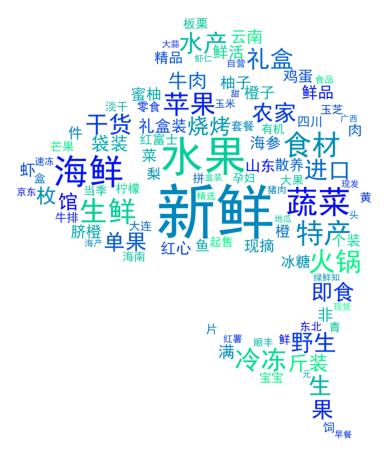

In [5]:
#将商品名称合并为一个字符串
freshtext = fresh['name'].dropna().agg(sum)

#分词并去除停用词
words = [w for w in jieba.lcut(freshtext) if w not in stopwords and w != ' ']

#生成词频字典
counts = Counter(words)

#生成元组列表
items = list(counts.items())

#根据词频排序，取前100个(频数大于排名第101的词)
items.sort(key = lambda x:x[1], reverse = True)
frequency = items[100][1]
countFrequency = {}
for word, fre in items:
    if fre > frequency:
        countFrequency[word] = fre

#绘制词云图
plt.figure(figsize = (6,8), dpi = 80) #创建画布
fresh_wc = WordCloud(background_color = 'white' #背景颜色
                    ,width = 2000 #宽度
                    ,height = 1200 #高度
                    ,font_path = 'simhei.ttf' #字体黑体
                    ,colormap = 'winter' #颜色
                    ,prefer_horizontal = 1 #水平显示词汇的比例
                    ,mask = imread('fish.jpg')
                    ,max_font_size = 400 #最大频数的字体
                    ,min_font_size = 20 #最小频数的字体
                    )
fresh_wc.fit_words(countFrequency) #根据词频绘图
plt.axis(False) #不显示坐标
plt.imshow(fresh_wc) #显示图片

解读：由第一类为生鲜的top100高频词的词云图可以看出，新鲜是最高频的词汇，此外还有生鲜以下的二级分类水果、海鲜和蔬菜也是较高频的词汇，其次是三级分类，如牛肉、苹果、烧烤和海参等。

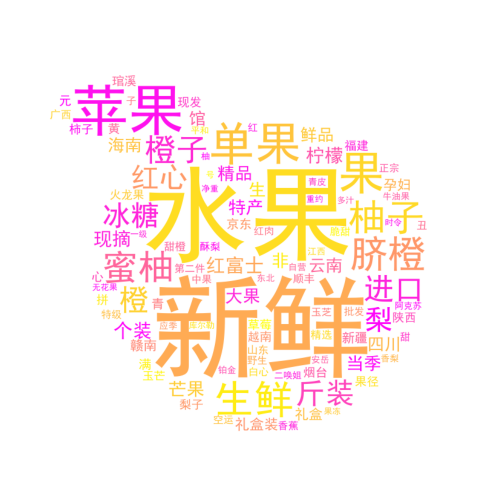

In [6]:
#将商品名称合并为一个字符串
fruittext = catalog[catalog['second'] == '水果']['name'].dropna().agg(sum)

#分词并去除停用词
words = [w for w in jieba.lcut(fruittext) if w not in stopwords and w != ' ']

#生成词频字典
counts = Counter(words)

#生成元组列表
items = list(counts.items())

#根据词频排序，取前100个(频数大于排名第101的词)
items.sort(key = lambda x:x[1], reverse = True)
frequency = items[100][1]
countFrequency = {}
for word, fre in items:
    if fre > frequency:
        countFrequency[word] = fre

#绘制词云图
plt.figure(figsize = (8,8), dpi = 80) #创建画布
fresh_wc = WordCloud(background_color = 'white' #背景颜色
                    ,width = 2000 #宽度
                    ,height = 1200 #高度
                    ,font_path = 'simhei.ttf' #字体黑体
                    ,colormap = 'spring' #颜色
                    ,prefer_horizontal = 1 #水平显示词汇的比例
                    ,mask = imread('apple.jpg')
                    )
fresh_wc.fit_words(countFrequency) #根据词频绘图
plt.axis(False) #不显示坐标
plt.imshow(fresh_wc) #显示图片

解读：由第二类为水果的top100高频词的词云图可以看出，新鲜和水果是最高频的两个词汇，其次高频的词汇是水果的种类，即三级分类，如苹果、单果、柚子、蜜柚和脐橙等。

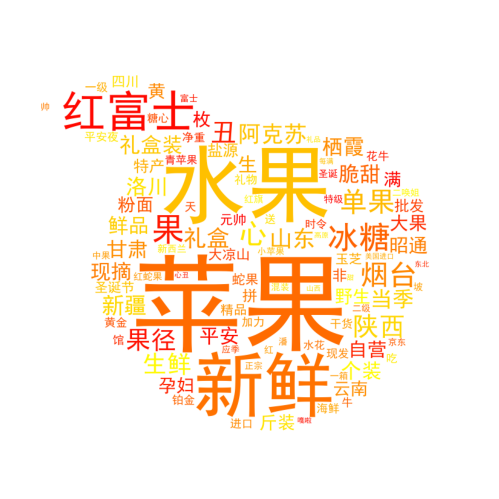

In [7]:
#将商品名称合并为一个字符串
appletext = catalog[catalog['third'] == '苹果']['name'].dropna().agg(sum)

#分词并去除停用词
words = [w for w in jieba.lcut(appletext) if w not in stopwords and w != ' ']

#生成词频字典
counts = Counter(words)

#生成元组列表
items = list(counts.items())

#根据词频排序，取前100个(频数大于索引为100的词)
items.sort(key = lambda x:x[1], reverse = True)
frequency = items[100][1]
countFrequency = {}
for word, fre in items:
    if fre > frequency:
        countFrequency[word] = fre

#绘制词云图
plt.figure(figsize = (8,8), dpi = 80) #创建画布
fresh_wc = WordCloud(background_color = 'white' #背景颜色
                    ,width = 2000 #宽度
                    ,height = 1200 #高度
                    ,font_path = 'simhei.ttf' #字体黑体
                    ,colormap = 'autumn' #颜色
                    ,prefer_horizontal = 1 #水平显示词汇的比例
                    ,mask = imread('apple.jpg')
                    )
fresh_wc.fit_words(countFrequency) #根据词频绘图
plt.axis(False) #不显示坐标
plt.imshow(fresh_wc) #显示图片

解读：由第三类为苹果的top100高频词的词云图可以看出，苹果、新鲜和水果是最高频的三个词汇，其次是苹果的品种或产地，如红富士、烟台、山东、阿克苏、新疆、陕西和甘肃等。

## 任务五

接下来，我们需要构建最后用于建模的数据集。首先，我们需要从全部分词结果中挑选出用于分类的特征词，这需要你完成如下几步：<br>
（1）将分词后的数据集按照7:3比例随机拆分为训练集和测试集。我们会在训练集上建模，然后在测试集上评估模型效果。<br>
（2）除了对原始数据进行拆分外，你还需要对分词后的数据集进行拆分。<br>
（3）分词结果需要进行预处理，请去掉数字字母组合，你可以选择将数字字母放到stopwords，然后通过itoken函数来更新分词结果。<br>
（4）去掉低频词（包含该词的商品数量<10）、高频词（在多于75%的商品名称中出现），在去除低频词和高频词时，你可以使用函数pruned_vocab()。<br>
（5）保留高频词中的top1000的词语，作为分类器的特征，这一步你可以利用pruned_vocab函数。<br>
最后，查看最终保留的top1000词语中的前20，并输出结果。

In [8]:
catalog = catalog.dropna() #删除含有缺失值的数据：1条
catalog.index = range(len(catalog)) #重置索引

#提取商品名称和二级分类
X = catalog[['name']] #商品名称
y = catalog[['second']] #二级分类

#分词、去除停用词
doc_counts = {} #含有某词的商品名称数量
term_counts = {} #某词的频数
for row in range(len(X)):
    term_result = [w for w in jieba.cut(X.name.values[row]) if w not in stopwords and w != ' ']
    doc_result = list(set(term_result)) #一个商品内去重
    for word in doc_result:
        doc_counts[word] = doc_counts.get(word, 0) + 1
    for word in term_result:
        term_counts[word] = term_counts.get(word, 0) + 1

#去除低频词和高频词
doc_items = list(doc_counts.items())
doc_items.sort(key = lambda x:x[1], reverse = True) #排序：含有某词的商品名称数量
countFrequency = {}
for word, fre in doc_items:
    if fre >= 10 and fre <= len(X)*0.75:
        countFrequency[word] = fre

#筛选出top1000
term_items = list(countFrequency.items())
term_items.sort(key = lambda x:x[1], reverse = True)
frequency = term_items[1000][1]
featureFinal = {}
for word, fre in term_items:
    if fre >= frequency:
        featureFinal[word] = fre

#生成top1000词语矩阵
featureX = pd.DataFrame.from_dict(featureFinal, orient = 'index')
featureX['term_counts'] = [term_counts[i] for i in featureX.index]
featureX = featureX.reset_index()
featureX.columns = ['term', 'doc_count', 'term_counts']
featureX.head(20)

,term,doc_count,term_counts
0,特产,14875,15224
1,新鲜,10725,12004
2,零食,10405,11310
3,茶叶,7257,8220
4,茶,6269,10155
5,水果,6008,6634
6,休闲,5465,5520
7,礼盒装,4818,5016
8,小吃,4465,4554
9,礼盒,4439,5175


## 任务六

接下来，根据上个任务选择的top1000词，构建最后用于建模的数据集，你需要完成如下几步：<br>
（1）我们根据保留的词语建立文档-词频矩阵。在建立文档词频矩阵时，你需要用到text2vec包中的create_dtm()函数。<br>
（2）得到文档词频矩阵后，进一步简化特征，将其转换成0-1矩阵，即包含该高频词取值为1，不包含该高频词取值为0。<br>
最后，以训练集为例，输出其前6篇文档在前5个特征词上的取值情况。<br>

In [9]:
#建立0-1矩阵
docFreqMatrix = pd.DataFrame(data = 0, index = range(len(X)), columns = featureX.term)
for row in range(len(X)):
    term_result = [w for w in jieba.cut(X.name.values[row]) if w not in stopwords and w != ' ']
    for word in term_result:
        if word in docFreqMatrix.columns:
            docFreqMatrix.loc[row, word] = 1
docFreqMatrix.iloc[0:6,0:5]

term,特产,新鲜,零食,茶叶,茶
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,1,0,0,0
5,0,0,0,0,0


## 任务七

以文档词频矩阵为自变量，以每个商品名称对应的二级分类为因变量，建立自动化分类模型。很多分类器都可以选择，但一般来说，朴素贝叶斯分类器对文本数据的分类效果较好，因此我们以朴素贝叶斯分类器来进行展示。<br>
对训练集建立朴素贝叶斯分类器，你需要用到e1071包里面的naiveBayes()函数。最后，使用建立的分类器对测试集中的商品进行预测，并计算测试集上的预测准确率。

In [10]:
#将标签列映射为数值
label_mapping = {'蔬菜': 1,
                 '地方特产': 2,
                 '水果': 3,
                 '休闲食品': 4,
                 '茗茶': 5,
                 '饮料冲调': 6,
                 '猪牛羊肉': 7,
                 '粮油调味': 8,
                 '食品礼券': 9,
                 '禽肉蛋品': 10,
                 '海鲜水产': 11,
                 '冷冻食品': 12,
                 '饮品甜品': 13}
y['second'] = y['second'].map(label_mapping)

#训练集:测试集=7:3
X_train, X_test, y_train, y_test = train_test_split(docFreqMatrix, y, test_size = 0.3, random_state = 1)

#建模
clf = MultinomialNB()
clf.fit(X_train,y_train)
score = clf.score(X_test, y_test)
print('二级品类：',score)

二级品类： 0.845884497313891


## 任务八

查看上述自动化分类器在各个二级品类上的预测准确率，使用混淆矩阵的形式进行展示。你如何看待最后的分类结果？

In [11]:
pred = clf.predict(X_test)
cm = confusion_matrix(y_test, pred)
pd.DataFrame(cm, index = label_mapping.keys(), columns = label_mapping.keys())

,蔬菜,地方特产,水果,休闲食品,茗茶,饮料冲调,猪牛羊肉,粮油调味,食品礼券,禽肉蛋品,海鲜水产,冷冻食品,饮品甜品
蔬菜,1243,52,44,13,7,1,1,65,8,4,9,34,0
地方特产,109,2637,21,311,88,42,11,400,67,8,42,20,9
水果,33,27,1619,9,1,3,0,2,3,0,32,2,1
休闲食品,7,224,8,1710,7,21,0,13,17,6,6,2,1
茗茶,4,33,3,21,3548,30,2,43,5,5,2,2,3
饮料冲调,0,16,0,9,14,1370,0,9,2,1,0,1,45
猪牛羊肉,5,23,2,12,1,1,483,11,9,7,6,15,1
粮油调味,62,274,8,63,44,38,6,2399,21,5,58,14,15
食品礼券,0,6,0,16,4,9,2,0,538,0,17,1,0
禽肉蛋品,9,37,1,17,7,1,21,4,2,491,5,13,0


解读：索引表示原数据集的类别，列名表示被分到的类别，因此对角线表示为分类正确的数量。有个别品种的分类效果不太好，比如地方特产、粮油调味和休闲食品之间的分类效果一般，饮料冲调和饮品甜品之间的分类效果也一般，对此的解释是这些分类之间本身存在交集。